In [1]:
import pandas as pd
from numpy import *

In [2]:
import h5py

## Loading the data 

### Load T matrix

In [3]:
import matplotlib
matplotlib.style.use('publication23')

In [4]:
f['0.99Tc']['lightplightn']['Ca1'].keys()

NameError: name 'f' is not defined

In [5]:
f = h5py.File('./TmDataEpc.h5')

list(f.keys())

list(f['0.99Tc']['lightplightn'].keys())

ds = f['0.99Tc']['lightplightn']['Ca1']['wave0']

ds_1 = f['0.99Tc']['lightplightn']['Ca2']['wave0']

ds.shape

imT = ds[1, :, :] + 0*ds_1[1, :, :]
reT = ds[0, :, :]

erange_T = arange(0, 9.01, 0.05)
qrange_T = arange(0, 6.01, 0.05)

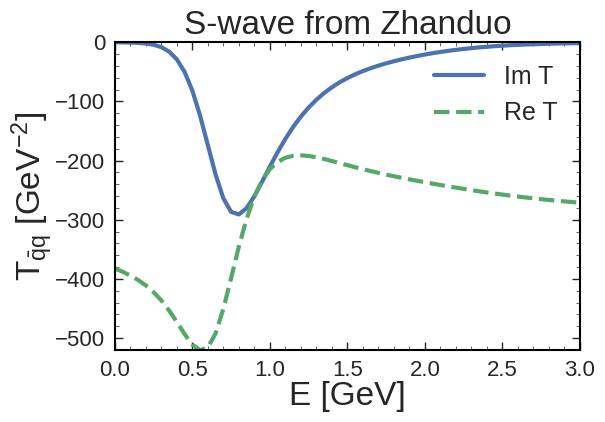

In [6]:
plt.plot(erange_T, 4*pi*imT[:, 0], label='Im T')
plt.plot(erange_T, 4*pi*reT[:, 0], label='Re T', ls='--')
plt.xlim(0, 3)

plt.xlabel('E [GeV]')
plt.ylabel(r'$T_{\bar q q}$ [GeV$^{-2}$]')

plt.legend()
plt.title('S-wave from Zhanduo')
plt.savefig('ReT.png', bbox_inches='tight')

### Load the SF

In [7]:
f_SF = h5py.File('./SF.h5')

list(f_SF.keys())

['lightp']

In [8]:
ds_SF = f_SF['lightp']
ds_SF.shape

(7381, 3)

In [9]:
ds_SF[0], ds_SF[1], ds_SF[2]

(array([-1.        ,  0.        , -0.00372613]),
 array([-0.95      ,  0.        , -0.00442894]),
 array([-0.9       ,  0.        , -0.00321106]))

In [10]:
len(arange(-1, 5.01, 0.05)), len(arange(0, 3.01, 0.05))

(121, 61)

In [11]:
df_Q = []

for i in range(121):
    df_Q += [ds_SF[i::121]]
    
df_Q = array(df_Q)

In [12]:
df_vals = zeros([121, 61])

In [13]:
for i in range(121):
    for j in range(61):
        df_vals[i, j] = df_Q[i, j, -1]

In [14]:
erange_SF = arange(-1, 5.01, 0.05)
qrange_SF = arange(0, 3.01, 0.05)

In [15]:
qrange_SF[20]

1.0

In [40]:
# len(erange_SF)

(-1.0, 2.0)

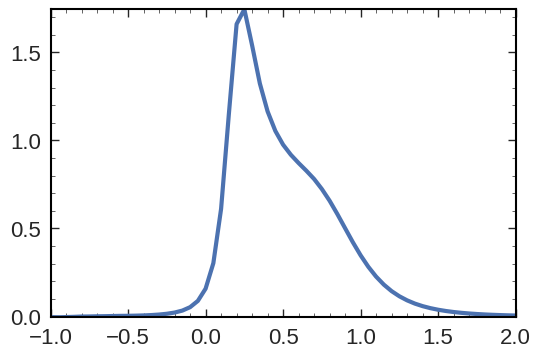

In [41]:
plt.plot(erange_SF, df_vals[:, 0])

plt.xlim(-1, 2)

In [17]:
df_Q = array(df_Q)

In [18]:
df_Q.shape

(121, 61, 3)

### Import the self-energy

In [19]:
f_SE = h5py.File('./SelfE_single.h5')

list(f_SE.keys())

['lightp']

In [20]:
ds_SE = f_SE['lightp']

In [21]:
ds_Im = ds_SE[1, :, :]

In [22]:
df_Im = []

for i in range(121):
    df_Im += [ds_Im[i::121]]
    
df_Im = array(df_Im)

df_Im_vals = zeros([121, 61])

for i in range(121):
    for j in range(61):
        df_Im_vals[i, j] = df_Im[i, j, -1]

In [23]:
ds_Re = ds_SE[0, :, :]

df_Re = []

for i in range(121):
    df_Re += [ds_Re[i::121]]
    
df_Re = array(df_Re)

df_Re_vals = zeros([121, 61])

for i in range(121):
    for j in range(61):
        df_Re_vals[i, j] = df_Re[i, j, -1]

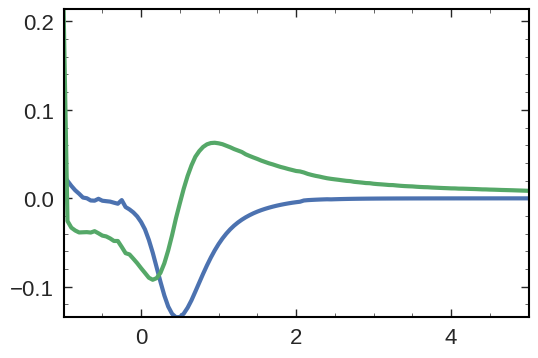

In [24]:
plt.plot(erange_SF, df_Im_vals[:, 0])
plt.plot(erange_SF, df_Re_vals[:, 0])

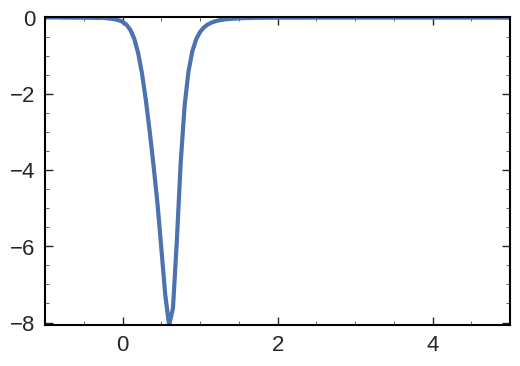

In [25]:
plt.plot(erange_SF, imag(1/(erange_SF - 0.57 - (df_Re_vals[:, 0] + 1j * df_Im_vals[:, 0]))))

# Run the calculation

In [26]:
import TMQGP as tm

In [27]:
iImT = tm.Interpolator2D(qrange_T, erange_T, imT)
iReT = tm.Interpolator2D(qrange_T, erange_T, reT)

In [28]:
iRho = tm.Interpolator2D(qrange_SF, erange_SF, df_vals)

In [29]:
res = array([tm.sigma_ff(e, 0, 0.194, iImT, iRho) for e in erange_SF])
# res = array([tm.E_integral(e, 0, 0.194, iImT, iRho) for e in erange_SF])

In [30]:
eps1 = tm.Interpolator(qrange_SF, sqrt(0.57**2 + qrange_SF**2), 'linear')
eps2 = tm.Interpolator(qrange_SF, sqrt(0.57**2 + qrange_SF**2), 'linear')

In [31]:
erange = linspace(-5, 5, 200)

In [32]:
res_onshell = array([tm.sigma_ff_onshell(e, 0, 0.194, iImT, iRho,
                                        eps1, eps2)
                     for e in erange])

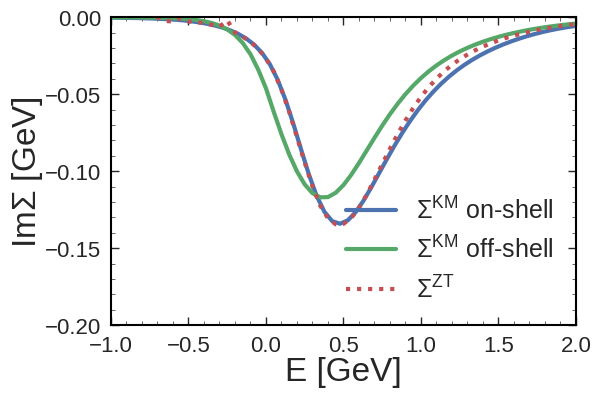

In [33]:
# plt.plot(erange_SF, 2*4*pi*2*pi*res/6*4, label=r'$(4\pi)(2\pi) \Sigma^{KM}$', ls='--')
plt.plot(erange, 3*4*pi*res_onshell/6*4, label=r'$\Sigma^{KM}$ on-shell')
plt.plot(erange_SF, 3*4*pi*res/6*4, label=r'$\Sigma^{KM}$ off-shell')
plt.plot(erange_SF, df_Im_vals[:, 0], ls=':', label=r'$\Sigma^{ZT}$')
plt.legend()

plt.xlabel('E [GeV]')
plt.ylabel(r'Im$\Sigma$ [GeV]')

plt.xlim(-1, 2)
plt.ylim( -0.2, 0)
plt.savefig('sigma_ff_compare_3x.pdf', bbox_inches='tight')

In [35]:
from scipy.integrate import quad

In [36]:
quad(lambda z: iRho(0, z), -1, 3)

/tmp/ipykernel_175745/3364335622.py:1: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad(lambda z: iRho(0, z), -1, 3)


(1.0000548693218654, 5.174933402719809e-08)